In [93]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
# Load the training set
df = pd.read_csv('training_data/utah_training_set.csv')

C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
df.columns

Index(['join_key', 'timestamp', 'SegID', 'station_id', 'KDE_Severity',
       'PREDIR', 'STREETTYPE', 'SPEED', 'ONEWAY', 'SURFTYPE', 'SURFWIDTH',
       'aadt_vn', 'Sinuosity', 'AtIntersection', 'hour', 'weekday', 'month',
       'target', 'snowing', 'raining', 'foggy', 'icy', 'hailing',
       'thunderstorm', 'wind_speed', 'visibility', 'temperature',
       'precip_depth', 'snow_depth'],
      dtype='object')

In [98]:
# Convert PREDIR into binary variables, for whatever it's worth.
PREDIR = pd.get_dummies(df['PREDIR'])
SURFTYPE = pd.get_dummies(df['SURFTYPE'])


# Continuous Features
These are currently:
* Severity Density (KDE estimate)
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT (Annual Average Daily Traffic)
* Precipitation Depth
* Snow Depth
* Temperature
* Visibility
* Wind SPeed

In [99]:
float_feature_names = [
    'KDE_Severity',
    'SPEED',
    'ONEWAY',
    'SURFWIDTH',
    'Sinuosity',
    'aadt_vn',
    'precip_depth',
    'snow_depth',
    'temperature',
    'visibility',
    'wind_speed'
]
float_features = df.xs(float_feature_names,axis=1).values

# Not using sklearn's scaler because I have a bunch of missing data and was feeling lazy. :)
mean_float = np.nanmean(float_features,axis=0)
std_float = np.nanstd(float_features,axis=0)

float_scaled = (float_features - mean_float) / std_float

with open('scalers.pkl','wb') as fp:
    pickle.dump((float_feature_names,mean_float,std_float),fp)


C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


# Temporal Features
These are important. I went back and forth on one-hot encoding vs treating them as continuous values. It didn't seem to make much difference so I'm leaving them at numbers.

In [100]:
# We can one hot encode the time values, but I've found this to be unneccesary in this case. 
time_feature_names = ['hour','weekday','month']
time_features = df.xs(time_feature_names,axis=1)
ohe = None
#ohe = OneHotEncoder(sparse=False)
#time_features = ohe.fit_transform(time_features)
'''
time_feature_names = []
for i in range(24):
    time_feature_names.append('hour{}'.format(i))
for i in range(7):
    time_feature_names.append('weekday{}'.format(i))
for i in range(12):
    time_feature_names.append('month{}'.format(i))
'''

"\ntime_feature_names = []\nfor i in range(24):\n    time_feature_names.append('hour{}'.format(i))\nfor i in range(7):\n    time_feature_names.append('weekday{}'.format(i))\nfor i in range(12):\n    time_feature_names.append('month{}'.format(i))\n"

In [101]:
binary_feature_names = [
    'raining',
    'snowing',
    'hailing',
    'icy',
    'foggy',
    'thunderstorm',
    'AtIntersection'
]
binary_features = df.xs(binary_feature_names,axis=1)

In [102]:
other_feature_names = PREDIR.columns.tolist()[1:]+SURFTYPE.columns.tolist()[1:]
other_features = np.hstack((PREDIR.values[:,1:],SURFTYPE.values[:,1:]))

In [103]:
X = np.hstack((time_features,float_scaled,binary_features,other_features)).astype('float64')
y = df['target'].values

In [104]:
feature_names = time_feature_names+float_feature_names+binary_feature_names+other_feature_names
print(feature_names)

['hour', 'weekday', 'month', 'KDE_Severity', 'SPEED', 'ONEWAY', 'SURFWIDTH', 'Sinuosity', 'aadt_vn', 'precip_depth', 'snow_depth', 'temperature', 'visibility', 'wind_speed', 'raining', 'snowing', 'hailing', 'icy', 'foggy', 'thunderstorm', 'AtIntersection', 'E', 'N', 'S', 'W', '200', '300', 'DIRT', 'IMPROVED', 'OTHER', 'PAVED']


In [105]:
wrangler = {
    'float_scaler_mean': mean_float,
    'float_scaler_std': std_float,
    'float_feature_names': float_feature_names,
    'time_feature_names': time_feature_names,
    'binary_feature_names': binary_feature_names,
    'time_ohe':ohe,
    'dummy_fields': ['PREDIR','SURFTYPE']
}
with open('wrangler.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
print (X_train.shape,y_train.shape)
print (X_test.shape,y_test.shape)
X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=feature_names)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=feature_names)
params = {
    'n_estimators': 2000,
    'max_depth':6,
    'reg_lambda': 0.0,
    'reg_alpha':1.0
}
booster = xgboost.train(params,X_train)

y_pred_test = np.round(booster.predict(X_test))
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

num_accidents_predicted_correctly = np.sum((y_test > 0) * (y_pred_test > 0))
num_accidents = np.sum(y_test > 0)

print ('Fraction Predicted:',num_accidents_predicted_correctly/float(num_accidents))
print ('Fraction False Alarm',(np.sum(y_pred_test>0) - num_accidents_predicted_correctly)/float(num_accidents))
y_pred_train = np.round(booster.predict(X_train))
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

(829842, 31) (829842,)
(829842, 31) (829842,)
Test Accuracy: 0.811908772995
Test F1: 0.640162483171
Test Precision: 0.613249882952
Test Recall: 0.669545634289
Test AUC: 0.874510510887
Fraction Predicted: 1.0
Fraction False Alarm 3.00182286392
Train Accuracy: 0.811515927128
Train F1: 0.640276717294
Train Precision: 0.612522386549
Train Recall: 0.670665606707
Train AUC: 0.874136857712


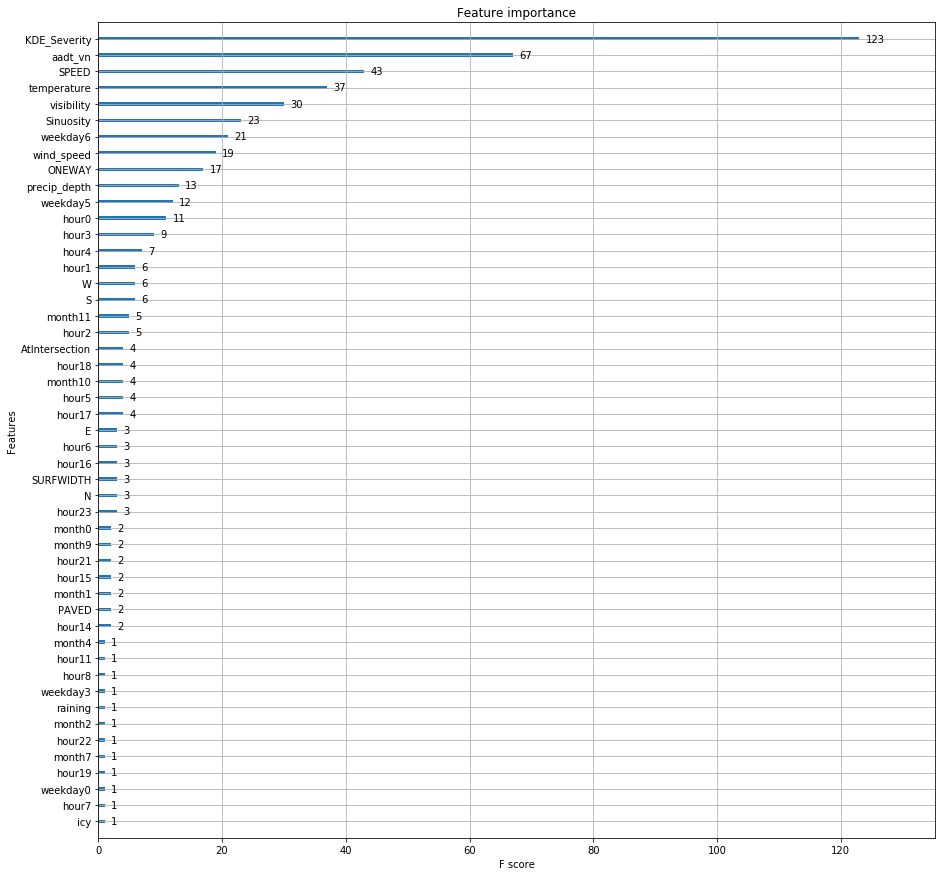

In [76]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca())

In [81]:
booster.save_model('0001.model')

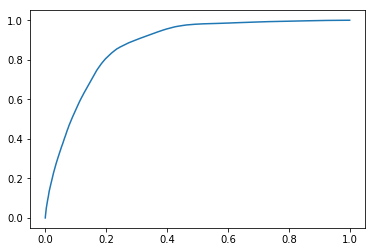

In [111]:
y_pred_test = booster.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

plt.plot(fpr,tpr)